In [1]:
# Building tranformer model from scratch using pytorch

Transformer model was introduced in the paper titled **"Attention is all you need"** by **Vaswani** et al.
The core idea behind it is the attention mechanism, specifically the concept of '**self-attention**,' which allows the model to weigh and prioritize different parts of the input data and focus on significant part while producing outputs.

1. With different words or features in the input sequence, it assigns each one a '**weight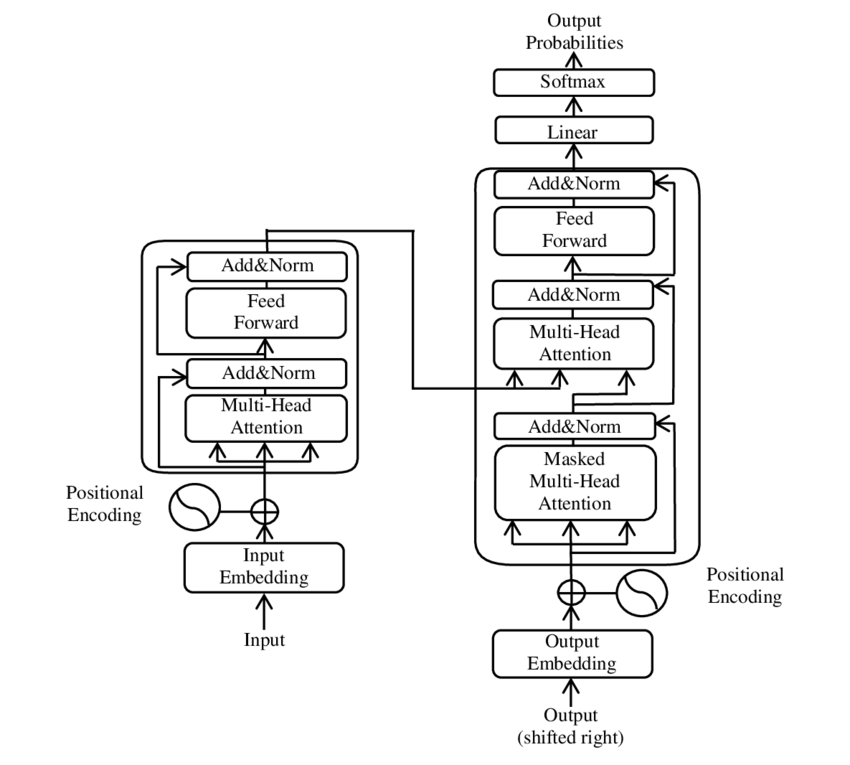**' that signifies its importance for producing a given output.
This process allows the Transformer to capture dependencies between words or features, **regardless of their distance** from each other in the sequence.

In [2]:
!mkdir /content/model

In [3]:
%%writefile /content/requirements.txt

torch
torchvision
torchaudio

Writing /content/requirements.txt


In [4]:
!pip install -r /content/requirements.txt

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [6]:
# import required torch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import torch.utils.data as data
import copy

# The transformer architecture from original paper


![](transformer_image.png)

It contains various important blocks:
1. Positional Encoding
2. Position-wise Feed-Forward Networks
3. Multi-Head Attention




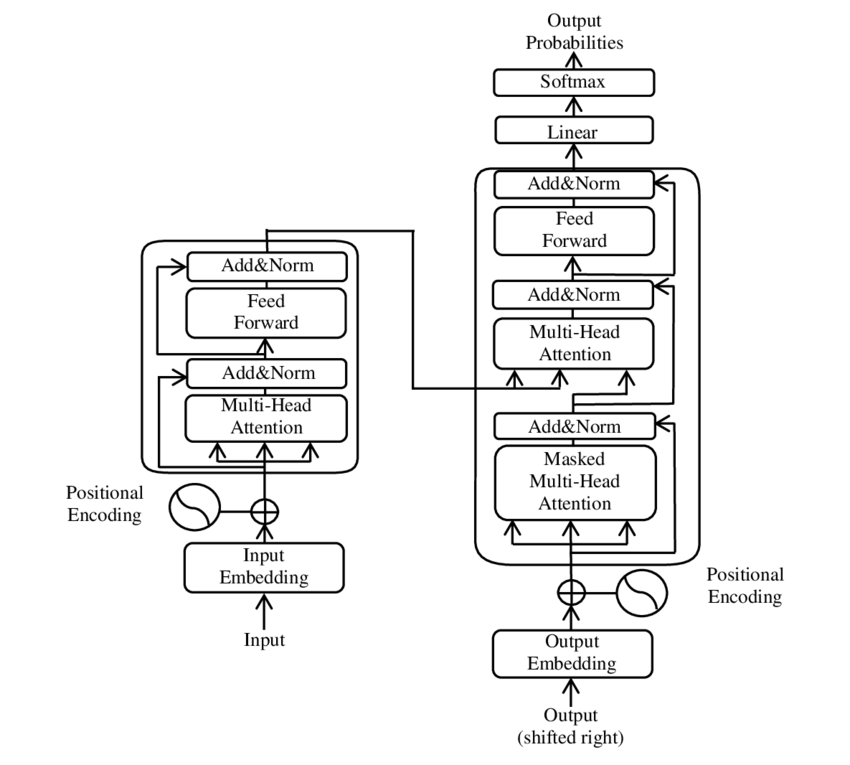

In [36]:
from IPython.display import Image
Image(filename='/content/transformer_image.png')
# Transformer architecture

In [15]:
# implementing Multi-head attention layer
"""
As per original paper, It contains 8 self-attention heads each with diemension of 64.
"""
class MultiHeadAttention(nn.Module):

  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    assert d_model % num_heads == 0 # to verify dimensions (d_model = 512, 8)

    self.d_model = d_model
    self.num_heads = num_heads
    self.head_dim = d_model // num_heads # 64 (each heads query, key and value)

    self.W_Q = nn.Linear(d_model, d_model)  # Query weight matrix (512, 512)
    self.W_K = nn.Linear(d_model, d_model)  # Key weight matrix
    self.W_V = nn.Linear(d_model, d_model)  # Value weight matrix
    self.W_O = nn.Linear(d_model, d_model)  # Output weight matrix


  def scaled_dot_product_attention(self, Q, K, V, mask=None):

    """
    Calculate the scaled dot product attention
    """
    attention_product = torch.matmul(Q, K.transpose(-2, -1))

    # add scaling factor of dimension of sqrt(head_dim) (= 8)
    attention_score = attention_product / math.sqrt(self.head_dim)

    # mostly used in decoder step and mask matrix is 0,1 matrix
    if mask is not None:
      attention_score = attention_score.masked_fill(mask == 0, -1e9)


    # apply softmax to get probability score for all keys per query
    attention_weights = F.softmax(attention_score, dim=-1)

    # multiple attention weights with Value matrix
    attention_output = torch.matmul(attention_weights, V)

    return attention_output


  def split_heads(self, x):
    """
    Split the last dimension
    It reshapes the input x into the shape (batch_size, num_heads, seq_length, d_k).
    It enables the model to process multiple attention heads concurrently, allowing
    for parallel computation.
    """
    batch_size, seq_len, d_model = x.size()  # B x L x 512
    # reshape into => B x 8 x L x 64
    return x.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)


  def combine_heads(self, x):
    """
    Combine the multiple heads back to original shape (batch_size, seq_length, d_model)
    """
    batch_size, num_heads, seq_len, d_k = x.size()  # B x 8 x L x 64
    # reshape into => B x L x 512
    return x.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)

  def forward(self, Q, K, V, mask=None):
    """
    combine all the steps like transformation, attention and output
    """
    Q = self.split_heads(self.W_Q(Q))
    # Q => B x 8 x L x 64
    K = self.split_heads(self.W_K(K))
    V = self.split_heads(self.W_V(V))

    # scaled dot product to get attention
    attention_output = self.scaled_dot_product_attention(Q, K, V, mask)

    # combine attention heads and pass through transformation weight matrix
    Output = self.W_O(self.combine_heads(attention_output))

    return Output


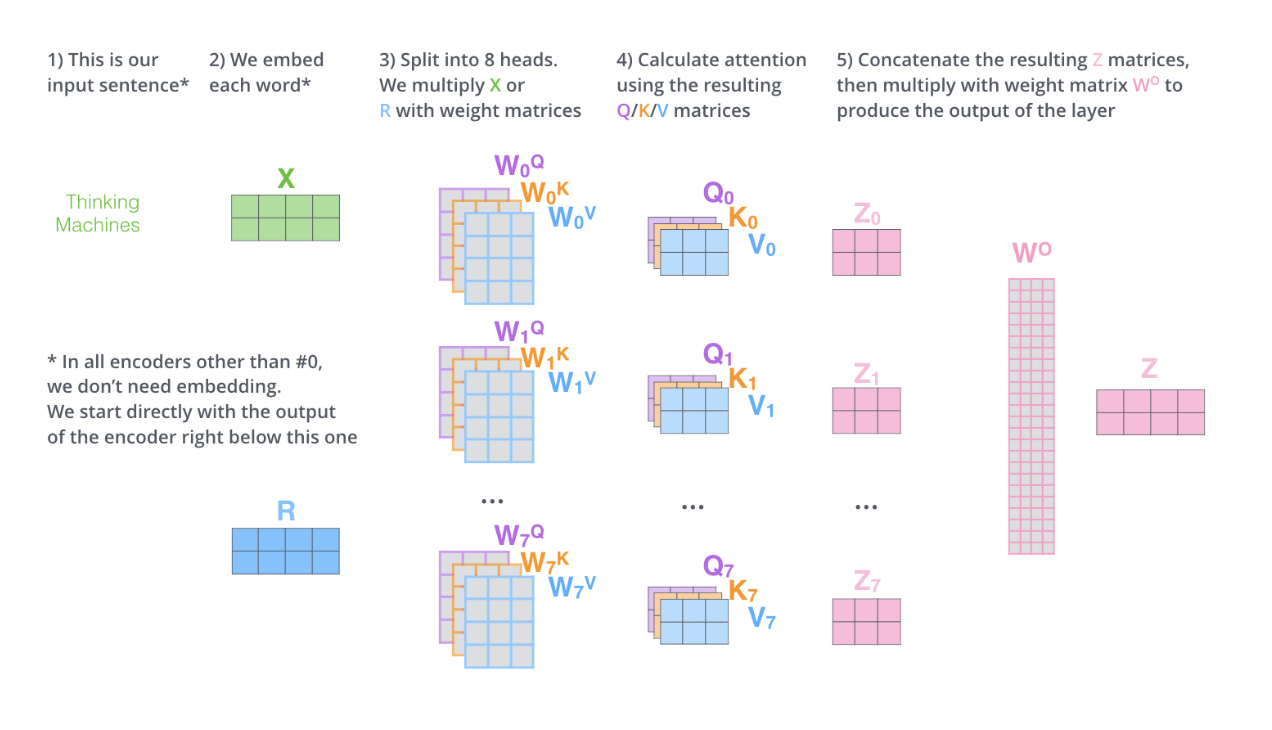

In [14]:
# Multihead attention process
Image(filename='/content/multihead_attention_process.png')

In [17]:
# Point wise FeedForward Neural Networks
"""
It is acting as an additional processing step for the attention outputs.
"""

class PointWiseFeedForward(nn.Module):

  def __init__(self, d_model, d_ff):
    super(PointWiseFeedForward, self).__init__()

    # d_model = dimension of the modelinput/output (512)
    # d_ff = dimension of hidden layer
    self.W_1 = nn.Linear(d_model, d_ff)
    self.W_2 = nn.Linear(d_ff, d_model)
    self.dropout = nn.Dropout(0.1) # avoid overfitting

  def forward(self, x):
    x = self.W_2(F.relu(self.W_1(x)))
    x = self.dropout(x)
    return x

In [29]:
# Implementing Positional Embedding
"""
Positional Encoding is used to inject the position information of each token
in the input sequence. It uses sine and cosine functions of different
frequencies to generate the positional encoding.

"""
# we add “positional encodings” to the input embeddings at the bottoms of
# the encoder and decoder stacks.

class PositionalEncoding(nn.Module):

  def __init__(self, d_model, max_seq_len):
    super(PositionalEncoding, self).__init__()
    self.d_model = d_model  # same dimension as embedding, 512
    self.max_seq_len = max_seq_len

    pe = torch.zeros(max_seq_len, d_model)  # create zeros matrix
    position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)

    # pe is registered as a buffer, which means it will be part of the
    # module's state but will not be considered a trainable parameter.
    self.register_buffer('pe', pe)

  def forward(self, x):
    # the positional encodings dimension should match the actual sequence length of x.
    return x + self.pe[:, :x.size(1)]


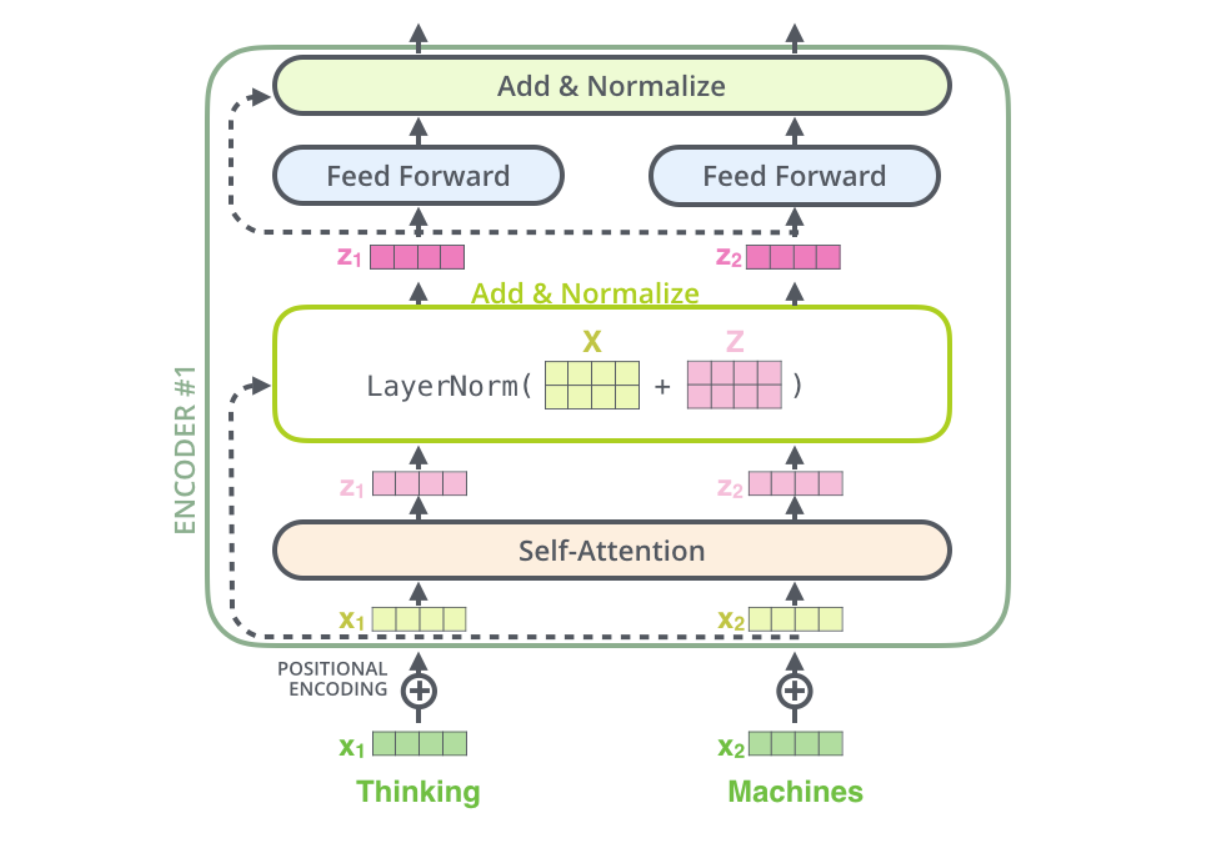

In [30]:
# Building the Encoder Layer using above components
Image(filename='/content/encoder_layer.png')

In [33]:
# implementing Encoder layer code
"""
It consists of following components:
1. Multi-head Attention  (1)
2. Point-wise Feed-Forward Networks (1)
3. Layer Normalization (2)
4. Dropout (1)
"""

class EncoderLayer(nn.Module):

  def __init__(self, d_model, d_ff, num_heads, dropout):
    super(EncoderLayer, self).__init__()

    self.d_model = d_model  # input dimension
    self.d_ff = d_ff  # hidden layer dimension
    sefl.num_heads = num_heads # number of heads

    self.multi_head_attention = MultiHeadAttention(d_model, num_heads)
    self.point_wise_feed_forward = PointWiseFeedForward(d_model, d_ff)
    self.layer_norm_1 = nn.LayerNorm(d_model)
    self.layer_norm_2 = nn.LayerNorm(d_model)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, mask):
    # step 1 : get multi-head self-attention
    attention_output = self.multi_head_attention(x, x, x, mask)

    # step 2: add residual before layer normalization (Add + normalize)
    x = self.layer_norm_1(x + self.dropout(attention_output))

    # step 3 : pass through Feedforward network (dropout is already done)
    ff_output = self.point_wise_feed_forward(x)

    # step 4: add residual before layer normalization (Add + normalize)
    x = self.layer_norm_2(x + ff_output)

    return x


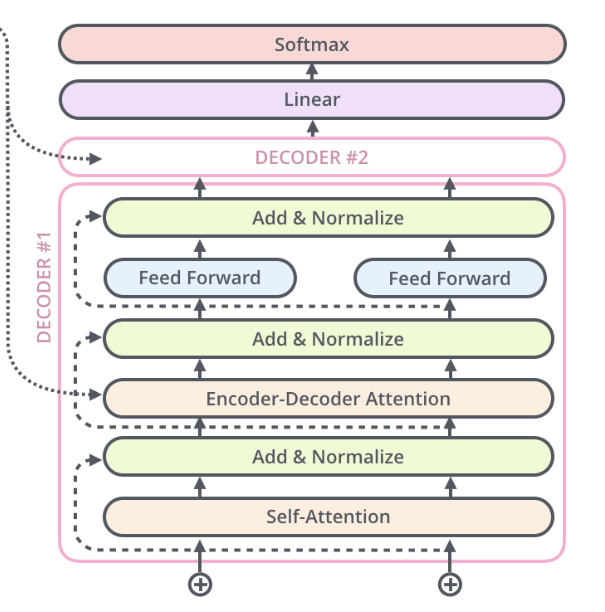

In [32]:
# Building the Decoder Layer using above components
Image(filename='/content/decoder_layer.png')

In [34]:
# implementing Decoder layer code
"""
 The encoder start by processing the input sequence. The output of the top encoder
 is then transformed into a set of attention vectors K and V. These are to be
 used by each decoder in its “encoder-decoder attention” layer which helps the
 decoder focus on appropriate places in the input sequence

It consists of following components:
1. Multi-head Attention  (1)
2. Point-wise Feed-Forward Networks (1)
3. Layer Normalization (3)
4. Dropout (1)
5. Encoder-Decoder Attention (1)
"""

"""
1. In the decoder, the self-attention layer is only allowed to attend to earlier
  positions in the output sequence. This is done by masking future positions
 (setting them to -inf) before the softmax step in the self-attention calculation.

2. The “Encoder-Decoder Attention” layer works just like multiheaded self-attention,
  except it creates its Queries matrix from the layer below it, and takes the Keys
  and Values matrix from the output of the encoder stack.

"""


class DecoderLayer(nn.Module):

  def __init__(self, d_model, d_ff, num_heads, dropout):
    super(DecoderLayer, self).__init__()

    self.d_model = d_model  # input dimension
    self.d_ff = d_ff  # hidden layer dimension
    self.num_heads = num_heads # number of heads

    self.multi_head_attention = MultiHeadAttention(d_model, num_heads)
    self.point_wise_feed_forward = PointWiseFeedForward(d_model, d_ff)
    self.layer_norm_1 = nn.LayerNorm(d_model)
    self.layer_norm_2 = nn.LayerNorm(d_model)
    self.layer_norm_3 = nn.LayerNorm(d_model)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, encoder_output, src_mask, tgt_mask):
    """
    encoder_output: output from the corresponding encoder (cross-attention step)
    src_mask: Source mask to ignore certain parts of the encoder's output
    tgt_mask: Target mask to ignore certain parts of the decoder's output
    """
    # step 1 : get multi-head self-attention
    attention_output = self.multi_head_attention(x, x, x, tgt_mask)

    # step 2: add residual before layer normalization (Add + normalize)
    x = self.layer_norm_1(x + self.dropout(attention_output))

    # step 3 : get encoder-decoder attention
    x = self.multi_head_attention(x, encoder_output, encoder_output, src_mask)

    # step 4: add residual before layer normalization (Add + normalize)
    x = self.layer_norm_2(x + self.dropout(attention_output))

    # step 5 : pass through Feedforward network (dropout is already done)
    ff_output = self.point_wise_feed_forward(x)

    # step 6: add residual before layer normalization (Add + normalize)
    x = self.layer_norm_3(x + ff_output)

    return x


In [35]:
# Combining both Encoder and Decoder layer to form the Transformer architecture

# the ouput of decoder layer pass through final Linear layer and softmax layer
# which turned into probability score for next token

class Transformer(nn.Module):

  def __init__(self, src_vocab_size, tgt_vocab_size, d_model, d_ff, num_layers, num_heads, max_seq_len, dropout):
    super(Transformer, self).__init__()

    self.d_model = d_model  # input dimension
    self.d_ff = d_ff  # hidden layer dimension
    self.num_layers = num_layers # number of Encoder/decoder layers
    self.num_heads = num_heads # number of heads

    self.encoder_embedding = nn.Embedding(src_vocab_size, d_model) # V x 512
    self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model) # V x 512
    self.positional_encoding = PositionalEncoding(d_model, max_seq_len)

    self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, d_ff, num_heads, dropout) for _ in range(num_layers)])
    self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, d_ff, num_heads, dropout) for _ in range(num_layers)])
    self.linear = nn.Linear(d_model, tgt_vocab_size)
    self.dropout = nn.Dropout(dropout)


  def generate_mask(self, src, tgt):

    src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
    tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
    seq_length = tgt.size(1)
    nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
    tgt_mask = tgt_mask & nopeak_mask

    return src_mask, tgt_mask


  def forward(self, src, tgt):

    src_mask, tgt_mask = self.generate_mask(src, tgt)

    src = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
    tgt = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

    enc_output = src
    for encoder_layer in self.encoder_layers:
      enc_output = encoder_layer(enc_output, src_mask)

    dec_output = tgt
    for decoder_layer in self.decoder_layers:
      dec_output = decoder_layer(dec_output, enc_output, src_mask, tgt_mask)

    # This linear layer would make the logits vector tgt_vocab_size cells wide –
    # each cell corresponding to the score of a unique word.
    output = self.linear(dec_output)

    # The softmax layer then turns those scores into probabilities (all positive,
    # all add up to 1.0). The cell with the highest probability is chosen, and
    # the word associated with it is produced as the output for this time step.
    output = F.softmax(output, dim=-1)

    return output
